# TUIA / AAII - TP2: Redes Recurrentes y Transformers - Problema 1

> *Modelo de Clasificación para inferir el dígito correspondiente a un clip de audio.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [1]:
!pip install pydub

In [2]:
# Data
import os
import pathlib
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from numpy.lib.stride_tricks import as_strided

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import plotly.graph_objects as go

# ML metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Redes Neuronales
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, Sequential
# from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, TimeDistributed, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Semillas para reproductibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### GPU

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor

https://www.tensorflow.org/datasets/catalog/spoken_digit

### Descarga

In [3]:
# Cargar el dataset spoken_digit
data, info = tfds.load('spoken_digit', with_info=True, as_supervised=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.82UCPB_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


## Análisis Exploratorio

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_dir=PosixGPath('/tmp/tmpkegu79oytfds'),
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    su

In [75]:
data.element_spec

(TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

* *Longitud de secuencia variable (shape=(None,)) en datos de entrada.*
* *Labels corresponde a un escalar (shape=()).*

In [5]:
tfds.as_dataframe(data.take(5), info)

audio  label
0  [0, 0, -256, 0, -256, 0, -256, 0, 0, 0, 0, 0, ...      2
1  [0, 0, 0, 0, -256, 0, -256, 0, -256, 0, -256, ...      1
2  [-10, -6, -25, -20, -17, -24, -26, -30, -30, -...      9
3  [0, 2, -3, -2, -2, -6, -1, -6, -8, -6, -8, -12...      9
4  [-256, 0, -256, 0, 0, -256, -256, 0, -512, 0, ...      7

In [7]:
shuffled_data = data.shuffle(len(data), seed=seed)
sample_data = shuffled_data.take(5)
df_sample = tfds.as_dataframe(sample_data, info)
df_sample

audio  label
0  [-548, -435, 27, -283, 802, -516, -72, 244, 21...      3
1  [-276, -65, -87, -430, -177, -151, 52, 369, -3...      3
2  [6, 9, 3, 2, 10, 7, 8, 6, 32, 31, 47, 43, 31, ...      1
3  [0, -256, -256, -256, -256, -256, 0, -256, -25...      6
4  [0, -10, -27, 29, -21, 9, -3, 15, -28, 29, -9,...      6

### Etiquetas

In [19]:
label_names = info.features['label'].names
print("Label names:", label_names)

Label names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [20]:
def label_histogram(ds, ds_title, w=10, h=5):
    # Contar las etiquetas en el dataset
    label_counts = {i: 0 for i in range(10)}

    for _, label in ds:
        label_counts[label.numpy()] += 1

    # Crear listas para las etiquetas y sus correspondientes conteos
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(w, h))
    plt.bar(labels, counts, tick_label=labels)
    plt.xlabel('Etiquetas (Dígitos)')
    plt.ylabel('Cantidad de Clips')
    plt.title(f'Cantidad de Clips por Etiqueta en "{ds_title}"')
    return plt.show()

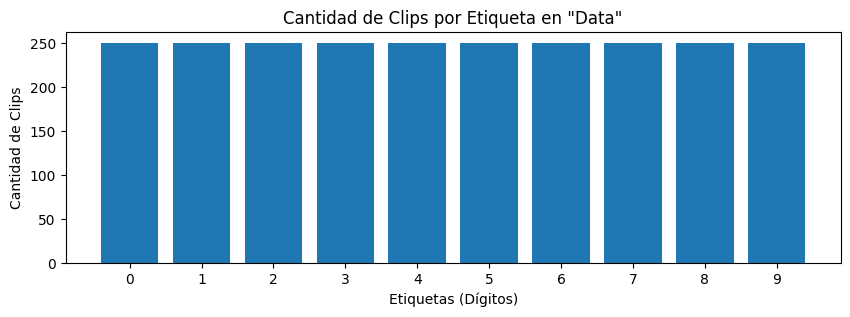

In [21]:
label_histogram(data, "Data", 10, 3)

### Muestras (Duración)

In [22]:
# Obtener la duración de cada clip de audio
def get_audio_duration(audio):
    return tf.shape(audio)[0]

# Obtener las duraciones de todos los clips de audio en el dataset
durations = np.array([get_audio_duration(audio) for audio, _ in data])

# Calcular el número total de clips de audio
num_clips = len(durations)

# Calcular la duración mínima, máxima y promedio de los clips de audio
min_duration = np.min(durations)
max_duration = np.max(durations)
avg_duration = np.mean(durations)

# Imprimir el resumen estadístico
print(f"Número total de clips de audio: {num_clips}")
print(f"Duración mínima de los clips de audio: {min_duration} muestras")
print(f"Duración máxima de los clips de audio: {max_duration} muestras")
print(f"Duración promedio de los clips de audio: {avg_duration} muestras")

Número total de clips de audio: 2500
Duración mínima de los clips de audio: 1148 muestras
Duración máxima de los clips de audio: 18262 muestras
Duración promedio de los clips de audio: 3280.632 muestras


In [23]:
def durations_boxplot(ds, ds_title, w=10, h=3):
    fig = go.Figure()
    fig.add_trace(go.Box(x=ds, orientation='h', name='Clips de Audio'))
    fig.update_layout(
        title=f'<b>Duraciones de Clips de Audio en "{ds_title}"</b>',
        title_x=0.5,  # Alinea el título en el centro del gráfic
        xaxis_title='Duración (muestras)',
        template='simple_white',
        height=h*100,
        width=w*100,
        xaxis=dict(
            tickvals=np.arange(0, np.max(ds) + 1000, 1000),
            ticktext=[f'{val//1000}k' for val in np.arange(0, np.max(ds) + 1000, 1000)]
        )
    )
    return fig.show()

In [24]:
durations_boxplot(durations, "Data", 10, 3)

In [25]:
def durations_histogram(ds, ds_title, w=10, h=5):
    # Definir los bins del histograma (de 1000 en 1000 muestras)
    bins = np.arange(0, np.max(ds) + 1000, 1000)

    plt.figure(figsize=(w, h))
    plt.hist(ds, bins=bins, edgecolor='lightblue')
    plt.xticks(np.arange(0, np.max(ds) + 1000, 1000), [f'{val//1000}k' for val in np.arange(0, np.max(ds) + 1000, 1000)])
    plt.title(f'Histograma de Duraciones de Clips de Audio en "{ds_title}"')
    plt.xlabel('Duración (muestras)')
    plt.ylabel('Cantidad de Clips')
    return plt.show()

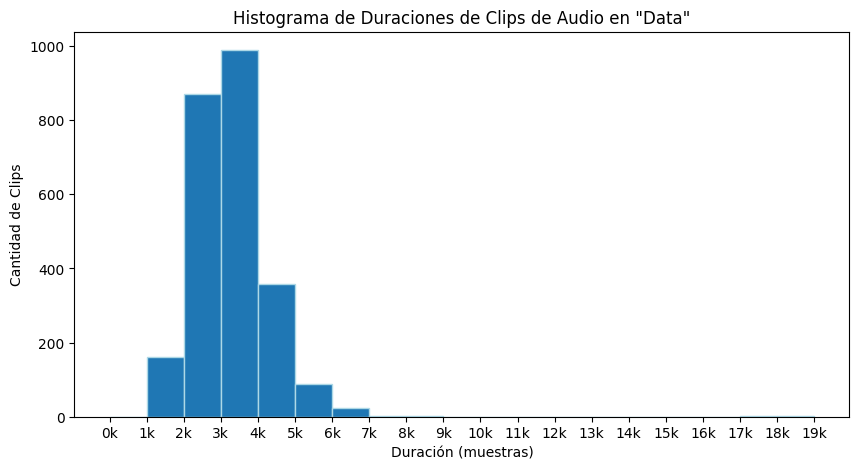

In [26]:
durations_histogram(durations, "Data", 10, 5)

## Conjuntos de Train y Val

In [78]:
# Contar el número de elementos en el dataset
data_size = len(data)

# Determinar el tamaño del conjunto de validación
val_size = int(data_size * 0.2)

# Shuffle del dataset antes de dividir
shuffled_data = data.shuffle(data_size, seed=seed)

# Crear datasets de entrenamiento y validación
train_ds = shuffled_data.skip(val_size)
val_ds = shuffled_data.take(val_size)

In [79]:
len(train_ds), len(val_ds)

(2000, 500)

In [80]:
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


## Procesamiento

### Normalizar las muestras

In [81]:
m_muestras = 8000  # 8000 equivale a 1 segundo de archivo wav a 8 kHz

In [82]:
def preprocess(audio, label):
    # Normalizar y convertir a float32
    audio = tf.cast(audio, tf.float32) / 32768.0

    # Asegurarse de que todos los audios tengan exactamente las muestras deseadas
    # Recortar si el audio es más largo; rellenar con ceros si es más corto
    audio = audio[:m_muestras]  # Recorta si es más largo que las muestras deseadas
    padding = tf.maximum(0, m_muestras - tf.shape(audio)[0])  # Cantidad de padding necesaria
    audio = tf.pad(audio, [[0, padding]], "CONSTANT")  # Aplicar padding

    return audio, label

In [83]:
# Aplicar el preprocesamiento al dataset
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

### Verificaciones

In [84]:
train_durations = np.array([get_audio_duration(audio) for audio, _ in train_ds])

In [85]:
durations_boxplot(train_durations, "Train", 8, 2)
durations_boxplot(train_durations, "Val", 8, 2)

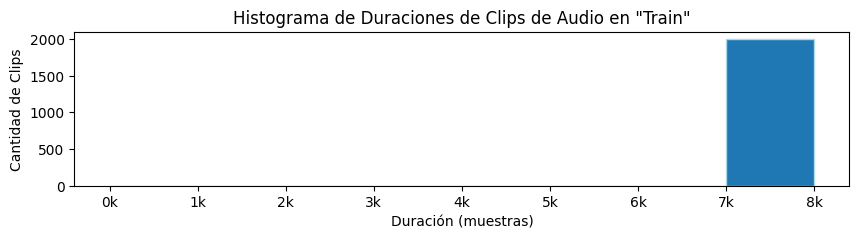

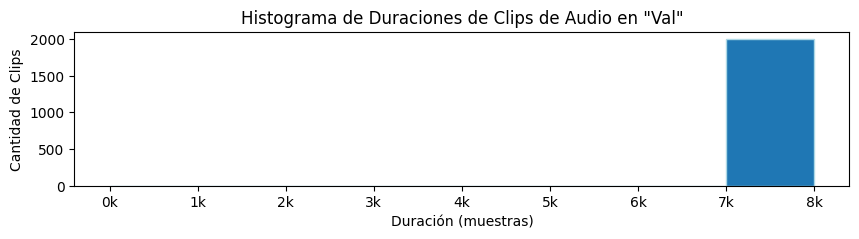

In [22]:
durations_histogram(train_durations, "Train", 10, 2)
durations_histogram(train_durations, "Val", 10, 2)

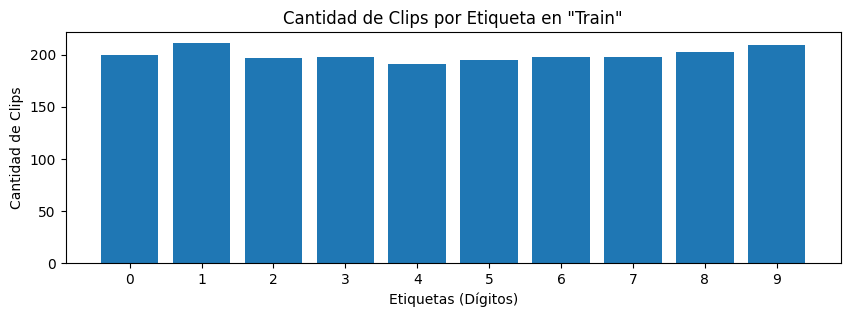

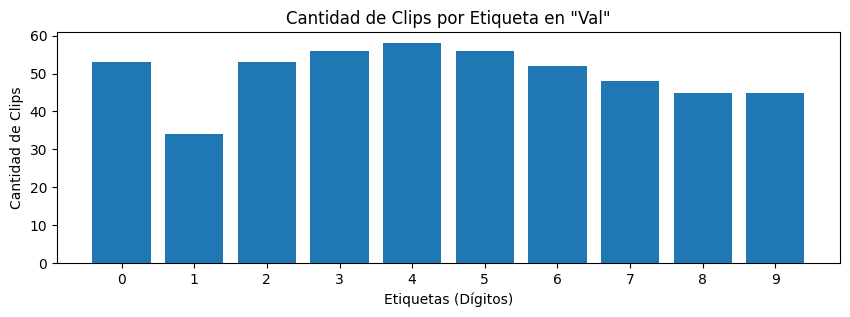

In [23]:
label_histogram(train_ds, "Train", 10, 3)
label_histogram(val_ds, "Val", 10.105, 3)

### Batch y Prefetch

In [86]:
# Batch y prefetch en los datasets
train_ds = train_ds.batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [87]:
# Iterar sobre un lote de datos en train_data
for audio, label in train_ds.take(1):
    print("Forma del audio en un lote:", audio.shape)  # Esto mostrará la forma del tensor de audio
    print("Forma de las etiquetas en un lote:", label.shape)  # Esto mostrará la forma del tensor de etiquetas

Forma del audio en un lote: (64, 8000)
Forma de las etiquetas en un lote: (64,)


## Visualizaciones

### Formas de Ondas

In [88]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

### Espectrogramas

In [89]:
def plot_spectrogram(spectrogram, ax):
    # Eliminar la dimensión extra innecesaria
    spectrogram = np.squeeze(spectrogram, axis=-1)

    # Convertir las frecuencias a escala logarítmica y transponer para que el tiempo esté representado en el eje x (columnas).
    log_spec = np.log(spectrogram + np.finfo(float).eps)
    ax.imshow(log_spec.T, aspect='auto', origin='lower')
    ax.set_ylabel('Frequency bins')
    ax.set_xlabel('Time')

### Muestras

Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


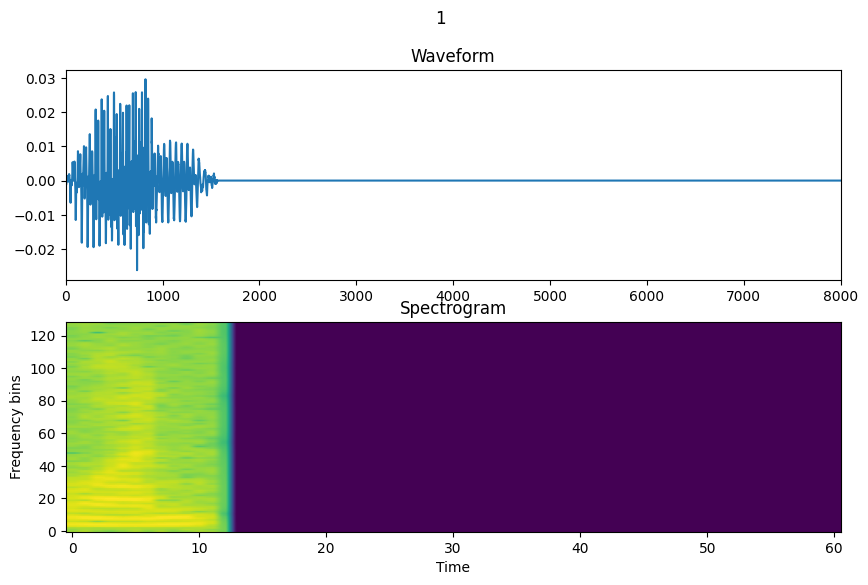

------------------------
Label: 2
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


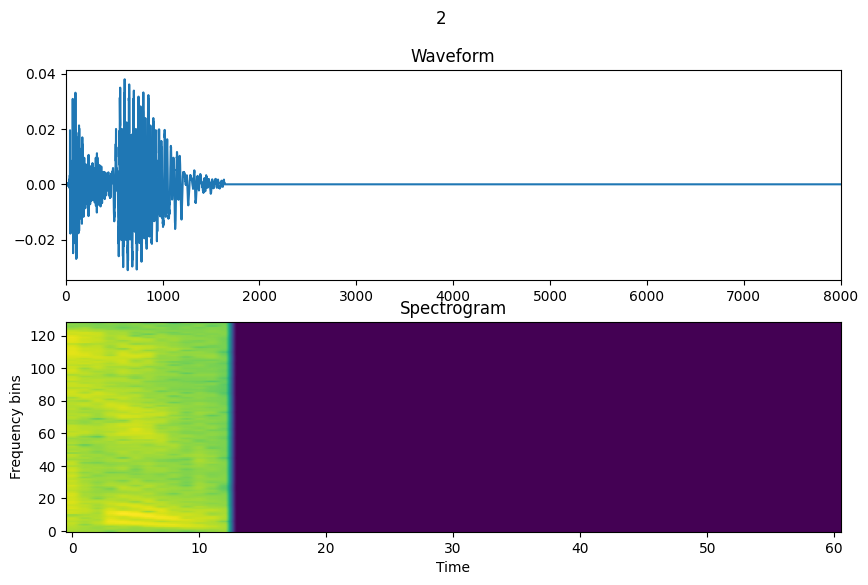

------------------------
Label: 2
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


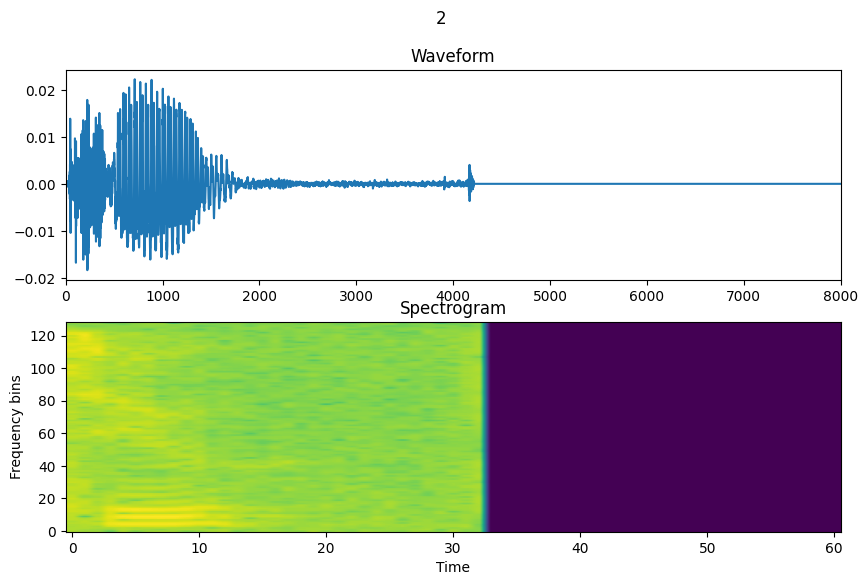

------------------------
Label: 8
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


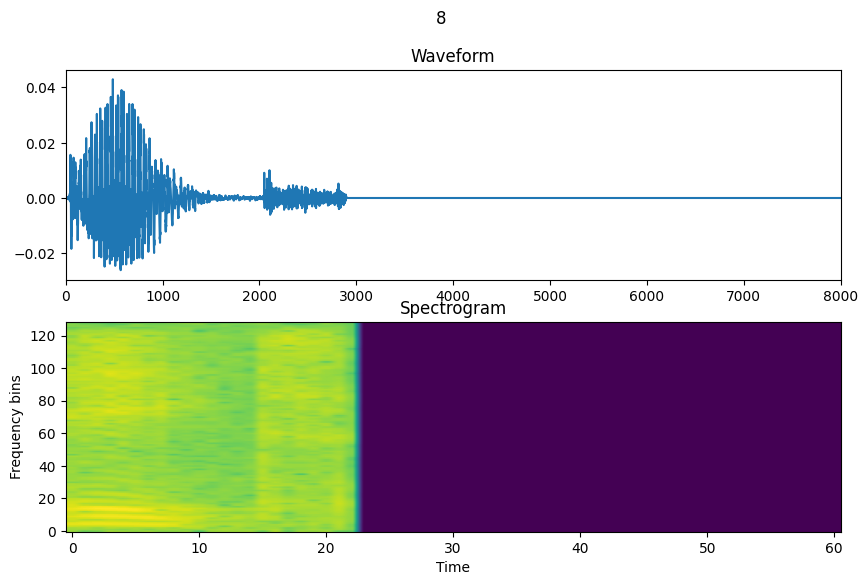

------------------------
Label: 9
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


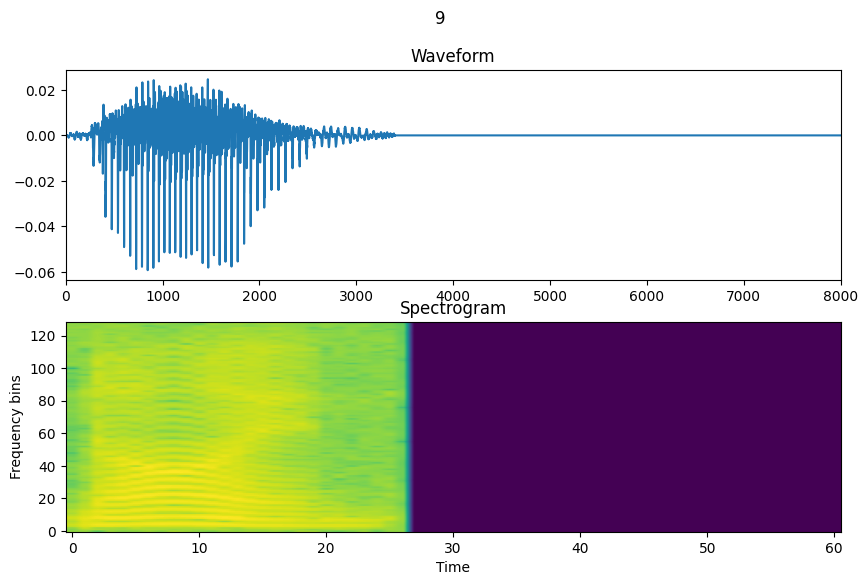

------------------------


In [90]:
# Procesando el lote de datos
for audio, label in train_ds.take(1):  # toma un lote del dataset
    for i in range(min(5, audio.shape[0])):  # Procesa solo los primeros ejemplos del lote
        waveform = audio[i].numpy()  # Extrae el audio y conviértelo a numpy
        label_index = label[i].numpy()  # Extrae el índice de la etiqueta y conviértelo a numpy
        label_name = label_names[label_index]  # Usa el índice para obtener el nombre de la etiqueta

        # Info y Playback
        print('Label:', label_name)
        print('Waveform shape:', waveform.shape)
        spectrogram = get_spectrogram(waveform)
        print('Spectrogram shape:', spectrogram.shape if spectrogram is not None else "Spectrogram not generated")
        print('Audio playback')
        display.display(display.Audio(waveform, rate=8000))

        # Visualizar la forma de onda
        fig, axes = plt.subplots(2, figsize=(10, 6))
        timescale = np.arange(waveform.shape[0])
        axes[0].plot(timescale, waveform)
        axes[0].set_title('Waveform')
        axes[0].set_xlim([0, waveform.shape[0]])

        # Visualizar el espectrograma
        plot_spectrogram(spectrogram.numpy(), axes[1])  # Asegura de que el espectrograma sea numpy y ajustado
        axes[1].set_title('Spectrogram')
        plt.suptitle(label_name.title())
        plt.show()
        print('------------------------')


## Dataset de Espectrogramas

In [91]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [92]:
# Create datasets of spectrograms for training and validation
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

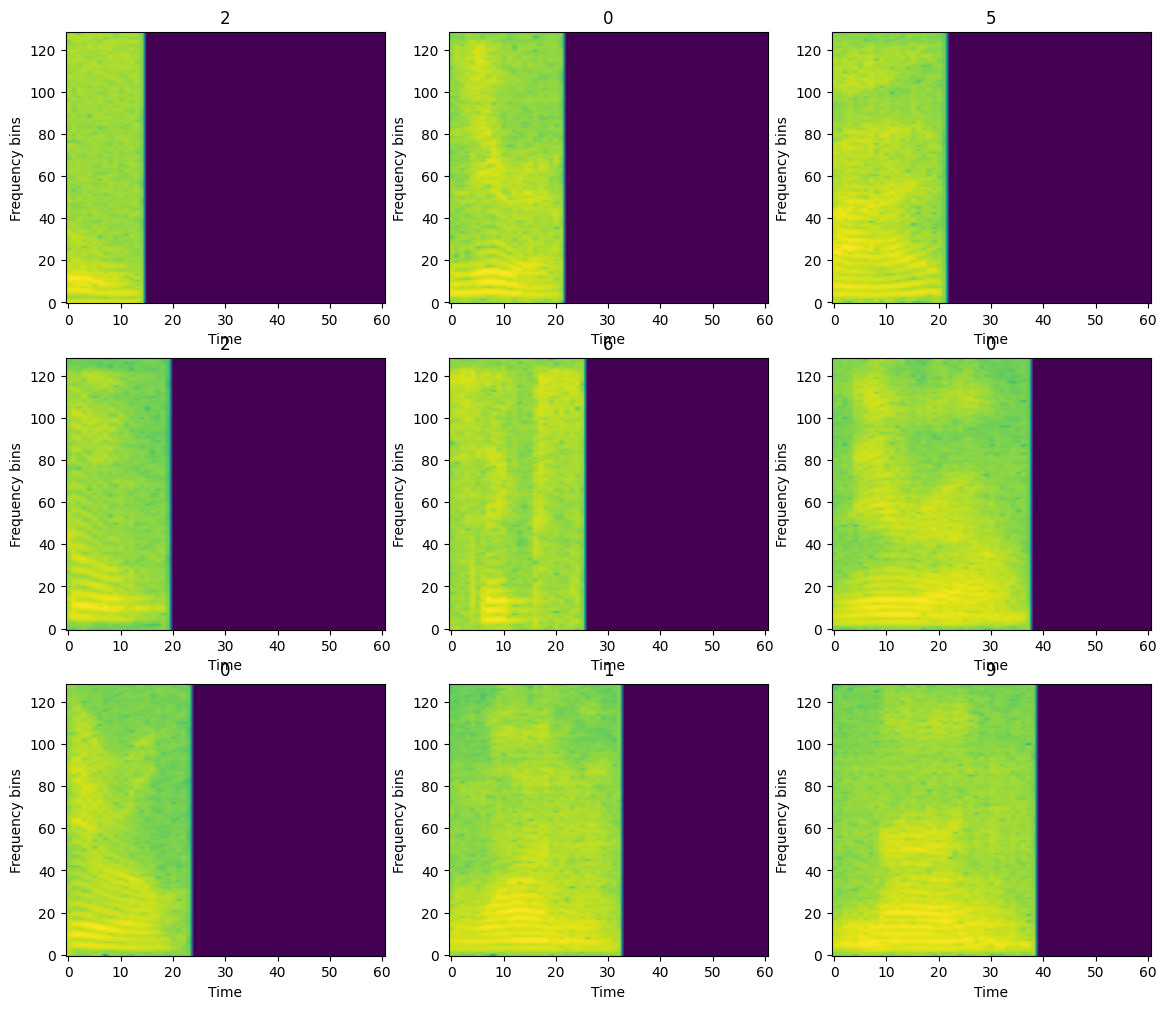

In [93]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 12))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Spectrogram shape: (61, 129, 1), Label: 6


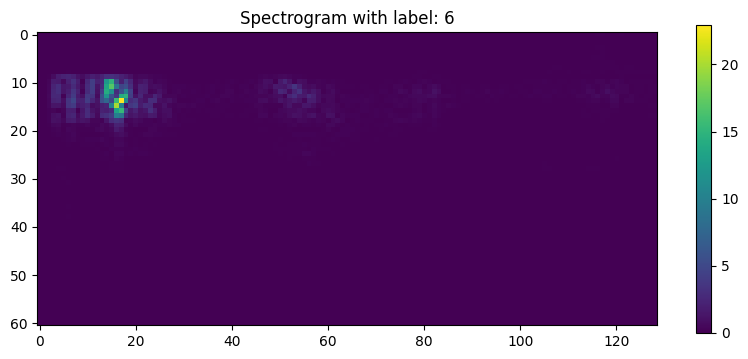

Spectrogram shape: (61, 129, 1), Label: 2


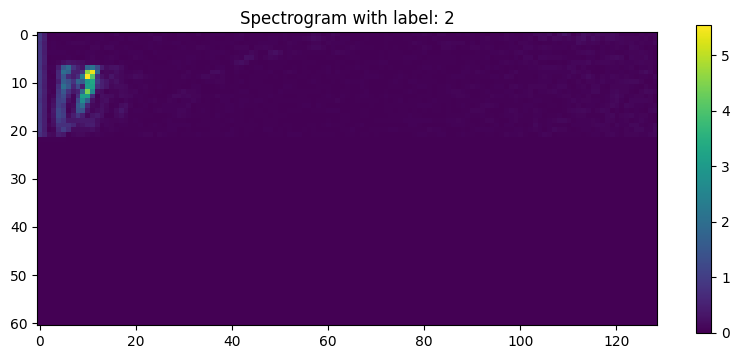

Spectrogram shape: (61, 129, 1), Label: 0


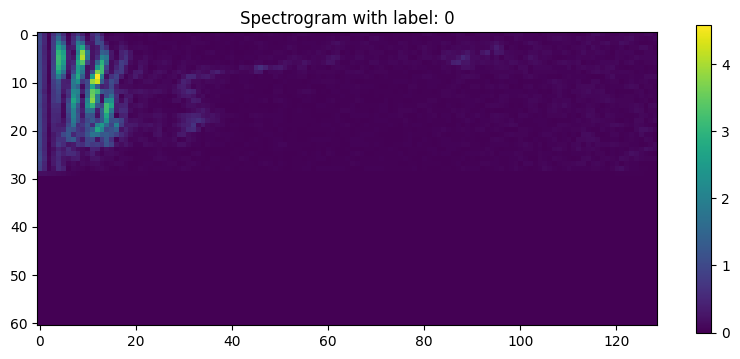

Spectrogram shape: (61, 129, 1), Label: 9


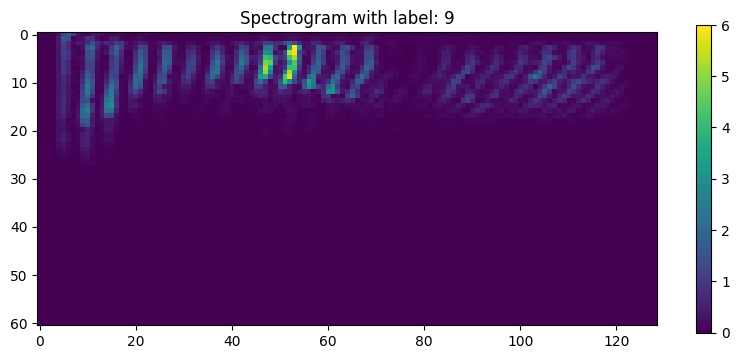

Spectrogram shape: (61, 129, 1), Label: 1


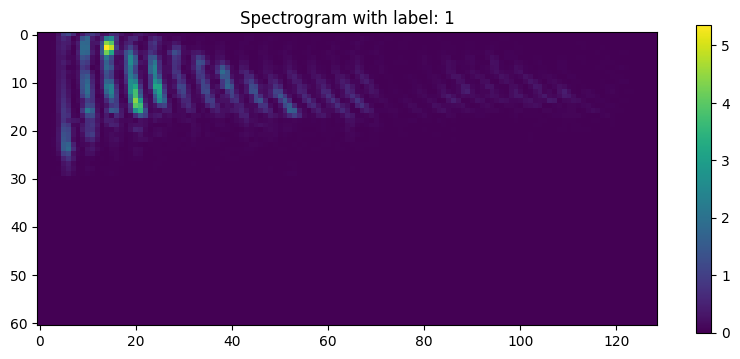

In [94]:
# Verificar un ejemplo del dataset de espectrogramas
for spectrograms, labels in train_spectrogram_ds.take(1):
    for i in range(5):  # Procesar los primeros 5 ejemplos del lote
        spectrogram = spectrograms[i]
        label = labels[i]

        print(f"Spectrogram shape: {spectrogram.shape}, Label: {label.numpy()}")

        # Mostrar el espectrograma
        plt.figure(figsize=(10, 4))
        plt.imshow(tf.squeeze(spectrogram).numpy(), cmap='viridis')
        plt.title(f"Spectrogram with label: {label.numpy()}")
        plt.colorbar()
        plt.show()

# CNN / Clasificación

In [80]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Modelo

### Definición y Entrenamiento

In [81]:
input_shape = spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_cnn.summary()

Input shape: (61, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)          

In [82]:
# Entrenamiento
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 30
print("Inicio del Entrenamiento CNN\n-------------------------")
history = model_cnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)
print("-------------------------\nFin del Entrenamiento CNN")

Inicio del Entrenamiento
-------------------------
Epoch 1/30
32/32 [==============================] - 11s 294ms/step - loss: 1.8251 - accuracy: 0.3885 - val_loss: 1.2771 - val_accuracy: 0.6180
Epoch 2/30
32/32 [==============================] - 6s 202ms/step - loss: 1.2055 - accuracy: 0.6075 - val_loss: 0.9088 - val_accuracy: 0.7540
Epoch 3/30
32/32 [==============================] - 10s 306ms/step - loss: 0.9047 - accuracy: 0.7145 - val_loss: 0.7139 - val_accuracy: 0.8420
Epoch 4/30
32/32 [==============================] - 8s 250ms/step - loss: 0.7001 - accuracy: 0.7815 - val_loss: 0.5938 - val_accuracy: 0.8880
Epoch 5/30
32/32 [==============================] - 7s 208ms/step - loss: 0.5752 - accuracy: 0.8120 - val_loss: 0.4992 - val_accuracy: 0.9180
Epoch 6/30
32/32 [==============================] - 8s 260ms/step - loss: 0.4630 - accuracy: 0.8530 - val_loss: 0.4232 - val_accuracy: 0.9320
Epoch 7/30
32/32 [==============================] - 8s 240ms/step - loss: 0.4061 - accuracy: 0.

### Métricas de Entrenamiento

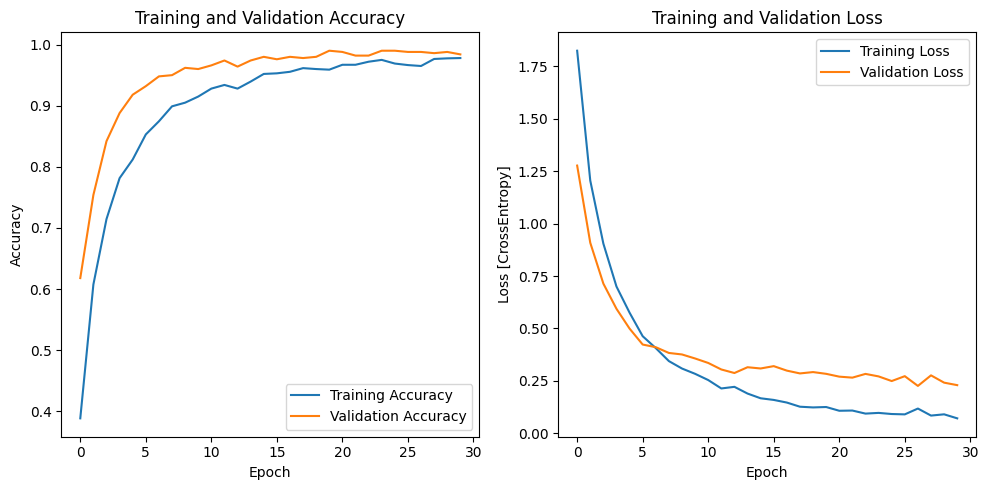

In [83]:
# Obtener las métricas de precisión y pérdida del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Usar el número de épocas del entrenamiento

plt.figure(figsize=(10, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Predicciones y Métricas

In [84]:
# Predicciones en el conjunto de prueba
y_pred = model_cnn.predict(val_spectrogram_ds)

8/8 [==============================] - 1s 80ms/step


In [85]:
y_pred = tf.argmax(y_pred, axis=1)

In [86]:
# Obtener las etiquetas verdaderas del conjunto de validación
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

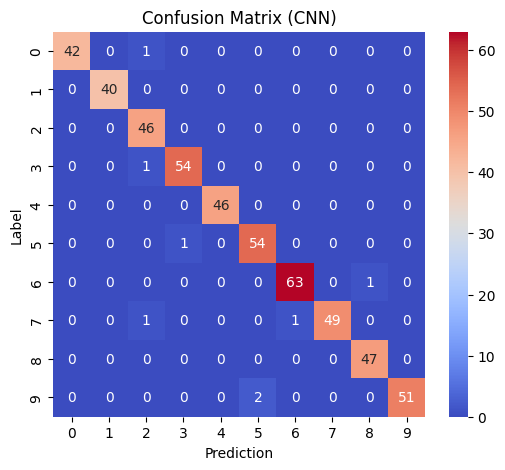

In [87]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix (CNN)')
plt.show()

In [88]:
# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names=label_names)

# Imprimir las métricas
print("--------------------------")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-Score: {:.2f}%".format(f1 * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

--------------------------
Accuracy: 98.40%
Precision: 98.45%
Recall: 98.40%
F1-Score: 98.40%

Confusion Matrix:
 [[42  0  1  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 46  0  0  0  0  0  0  0]
 [ 0  0  1 54  0  0  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  1  0 54  0  0  0  0]
 [ 0  0  0  0  0  0 63  0  1  0]
 [ 0  0  1  0  0  0  1 49  0  0]
 [ 0  0  0  0  0  0  0  0 47  0]
 [ 0  0  0  0  0  2  0  0  0 51]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       1.00      1.00      1.00        40
           2       0.94      1.00      0.97        46
           3       0.98      0.98      0.98        55
           4       1.00      1.00      1.00        46
           5       0.96      0.98      0.97        55
           6       0.98      0.98      0.98        64
           7       1.00      0.96      0.98        51
           8       0.98      1.00      0.99

## Inferencia

### Grabación en tiempo real

### Archivo grabado

Inferimos sobre un archivo de audio (archivo .wav completamente nuevo).

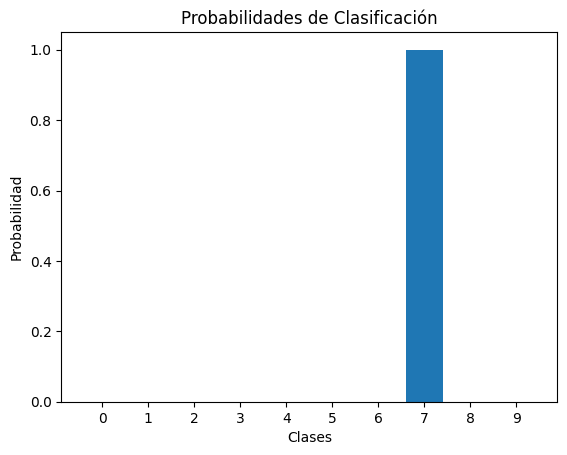

In [50]:
x = 'grab_07.wav'
display.display(display.Audio(waveform, rate=8000))

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model_cnn(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Probabilidades de Clasificación')
plt.xlabel('Clases')
plt.ylabel('Probabilidad')
plt.show()

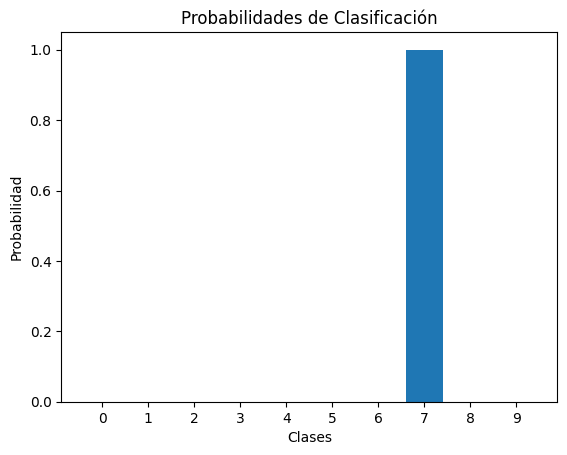

In [ ]:
x = 'grab_00.wav'
display.display(display.Audio(waveform, rate=8000))

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model_cnn(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Probabilidades de Clasificación')
plt.xlabel('Clases')
plt.ylabel('Probabilidad')
plt.show()

In [51]:
# Ruta al archivo de audio
file_path = 'grab_03.wav'

# Leer y decodificar el archivo de audio
audio_binary = tf.io.read_file(file_path)
waveform, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=8000)

# Ajustar el waveform para la visualización y predicción
waveform = tf.squeeze(waveform, axis=-1)

# Mostrar el audio
display.display(display.Audio(waveform, rate=8000))

In [52]:
# Normalizar y convertir a float32
waveform = tf.cast(waveform, tf.float32) / 32768.0

# Obtener el espectrograma
spectrogram = get_spectrogram(waveform)

# Añadir dimensión para batch
spectrogram = spectrogram[tf.newaxis, ...]

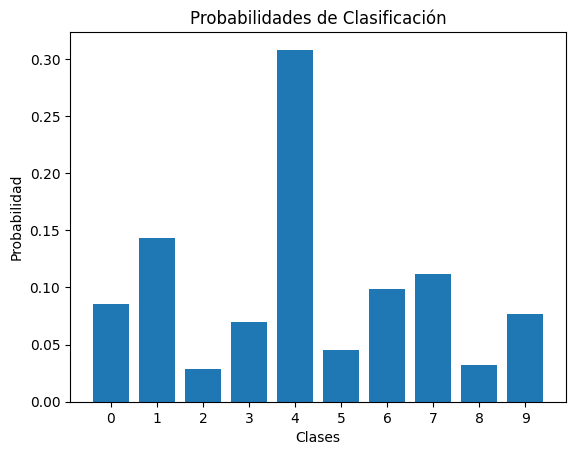

In [54]:
# Realizar la predicción
prediction = model_cnn(spectrogram)

# Obtener las probabilidades y etiquetas
probabilities = tf.nn.softmax(prediction[0])
x_labels = label_names

# Graficar las probabilidades
plt.bar(x_labels, probabilities)
plt.title('Probabilidades de Clasificación')
plt.xlabel('Clases')
plt.ylabel('Probabilidad')
plt.show()

# RNN / Clasificación

## Preprocesamiento de dataset

In [95]:
# Contar el número de elementos en el dataset
data_size = len(data)

# Determinar el tamaño del conjunto de validación
val_size = int(data_size * 0.2)

# Shuffle del dataset antes de dividir
shuffled_data = data.shuffle(data_size, seed=seed)

# Crear datasets de entrenamiento y validación
train_ds = shuffled_data.skip(val_size)
val_ds = shuffled_data.take(val_size)

In [96]:
m_muestras = 8000  # 8000 equivale a 1 segundo de archivo wav a 8 kHz

In [97]:
def preprocess(audio, label):
    # Normalizar y convertir a float32
    audio = tf.cast(audio, tf.float32) / 32768.0

    # Asegurarse de que todos los audios tengan exactamente las muestras deseadas
    # Recortar si el audio es más largo; rellenar con ceros si es más corto
    audio = audio[:m_muestras]  # Recorta si es más largo que las muestras deseadas
    padding = tf.maximum(0, m_muestras - tf.shape(audio)[0])  # Cantidad de padding necesaria
    audio = tf.pad(audio, [[0, padding]], "CONSTANT")  # Aplicar padding

    return audio, label

In [98]:
# Aplicar el preprocesamiento al dataset
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [99]:
# Batch y prefetch en los datasets
train_ds = train_ds.batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [100]:
# Función para obtener el espectrograma de un audio
def get_spectrogram(audio):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

# Función para crear lotes de espectrogramas con sus etiquetas
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [101]:
# Crear datasets de spectrogramas para entrenamiento y validación
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [102]:
# Mezclamos las instancias de entrenamiento, y las precargamos
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [103]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = 10
print('\nNumero de etiquetas:', num_labels)

Input shape: (61, 129, 1)

Numero de etiquetas: 10


In [105]:
# Instancia la capa de normalizacion.
norm_layer = layers.Normalization()

# Le paso el dataset con funcion adapt, para que calcule mean y sd para luego utilizarlos para normalizar
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec)) # Primero me quedo con dataset que conste solo de los espectrogramas para que calcule

Para utilizar Red Neuronal Recurrente queda un ultimo paso que seria de los dataset generados para las Convolucionales eliminar el último canal para poder trabajar con secuencias, cada secuencia corresponde a un paso de tiempo con valores de caracteristicas igual a la columna correspondiente en el espectrograma.

In [110]:
def rnn_preproc(spectrogram, label):
  spectrogram = tf.transpose(spectrogram, perm=[0, 1, 2]) # Reordena las dimensiones
  return spectrogram, label

In [ ]:
# def rnn_preproc(spectrogram, label):
#   spectrogram = tf.squeeze(spectrogram, axis=-1) # Eliminamos el ultimo eje (canales para imagenes)
#   return spectrogram, label

In [112]:
train_rnn_spectrogram_ds = train_spectrogram_ds.map(rnn_preproc)
val_rnn_spectrogram_ds = val_spectrogram_ds.map(rnn_preproc)

In [113]:
for lote in train_rnn_spectrogram_ds.take(1):
  print(lote[0].shape)
  print(lote[1].shape)

(64, 61, 129)
(64,)


* *En la forma tenemos batches de 64 que tienen 61 steps con 129 caracteristicas cada por instancia*

* *Con esto le entramos a la recurrente.*

In [114]:
# Mezclamos las instancias de entrenamiento, y las precargamos
train_rnn_spectrogram_ds = train_rnn_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_rnn_spectrogram_ds = val_rnn_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [115]:
# Cantidad de labels
num_labels = 10

# Input de la rnn
input_shape_rnn = tf.shape(lote[0][0]).numpy()
print(f'input_rnn: {input_shape_rnn}')

input_rnn: [ 61 129]


## Modelo

### Definición y Entrenamiento

In [119]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape_rnn),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # capa bidireccional con 64 celdas lstm, es decir 128 celdas
    # en total, y al final concatena la salida, por defecto no devuelven secuencias sino que devuelven el ultimo elemento
    # de cada celda
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128)               99328     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 108234 (422.79 KB)
Trainable params: 108234 (422.79 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [120]:
# Compilación del modelo
model_rnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_rnn_model.h5', monitor='val_loss', save_best_only=True)

# Entrenamiento del modelo RNN
EPOCHS = 30
print("Inicio del Entrenamiento RNN\n-------------------------")
history_rnn = model_rnn.fit(train_rnn_spectrogram_ds, epochs=EPOCHS,
                          validation_data=val_rnn_spectrogram_ds,
                          batch_size=64, callbacks=[early_stopping, model_checkpoint])
print("-------------------------\nFin del Entrenamiento RNN")

Inicio del Entrenamiento RNN
-------------------------
Epoch 1/30
32/32 [==============================] - 13s 295ms/step - loss: 2.1834 - accuracy: 0.2265 - val_loss: 1.8920 - val_accuracy: 0.4500
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



32/32 [==============================] - 6s 194ms/step - loss: 1.6830 - accuracy: 0.4135 - val_loss: 1.1561 - val_accuracy: 0.6740
Epoch 3/30
32/32 [==============================] - 5s 151ms/step - loss: 1.2051 - accuracy: 0.5855 - val_loss: 0.7499 - val_accuracy: 0.7920
Epoch 4/30
32/32 [==============================] - 4s 118ms/step - loss: 0.9122 - accuracy: 0.6745 - val_loss: 0.5617 - val_accuracy: 0.8360
Epoch 5/30
32/32 [==============================] - 6s 187ms/step - loss: 0.7105 - accuracy: 0.7635 - val_loss: 0.4091 - val_accuracy: 0.8780
Epoch 6/30
32/32 [==============================] - 4s 119ms/step - loss: 0.5606 - accuracy: 0.8115 - val_loss: 0.2992 - val_accuracy: 0.9080
Epoch 7/30
32/32 [==============================] - 4s 118ms/step - loss: 0.4628 - accuracy: 0.8530 - val_loss: 0.2541 - val_accuracy: 0.9240
Epoch 8/30
32/32 [==============================] - 7s 221ms/step - loss: 0.3581 - accuracy: 0.8840 - val_loss: 0.2029 - val_accuracy: 0.9220
Epoch 9/30
32/32 

### Métricas de Entrenamiento

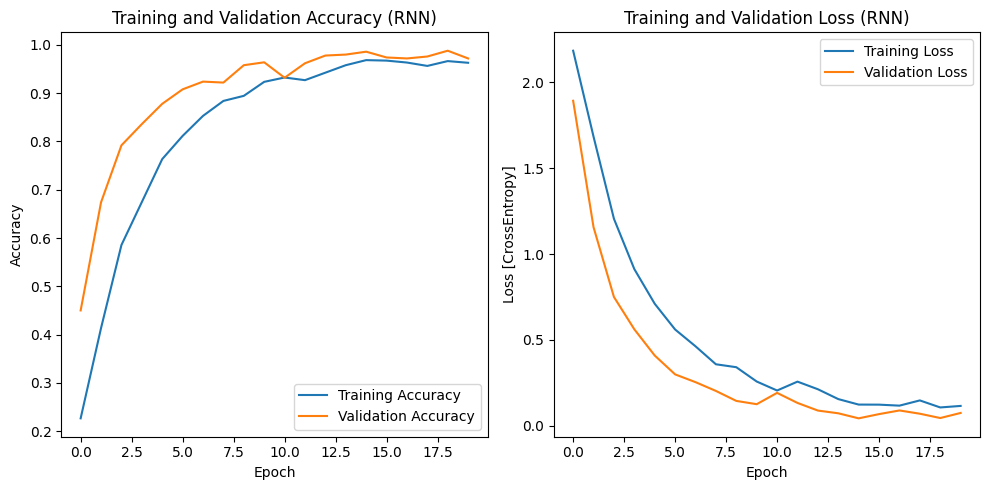

In [121]:
# Obtener las métricas de precisión y pérdida del historial
acc_rnn = history_rnn.history['accuracy']
val_acc_rnn = history_rnn.history['val_accuracy']

loss_rnn = history_rnn.history['loss']
val_loss_rnn = history_rnn.history['val_loss']

epochs_range_rnn = range(len(acc_rnn))  # Número de épocas

# Gráficos de precisión y pérdida para la RNN
plt.figure(figsize=(10, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range_rnn, acc_rnn, label='Training Accuracy')
plt.plot(epochs_range_rnn, val_acc_rnn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (RNN)')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range_rnn, loss_rnn, label='Training Loss')
plt.plot(epochs_range_rnn, val_loss_rnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('Training and Validation Loss (RNN)')
plt.legend()

plt.tight_layout()
plt.show()

## Predicciones y Métricas

In [131]:
# Predicciones en el conjunto de prueba
y_pred_rnn = model_rnn.predict(val_rnn_spectrogram_ds)

8/8 [==============================] - 1s 111ms/step


In [135]:
# Por cada prediccion obtengo los logits (si tuviera la softmax seria una distribucion de probabilidad), el
# indice del valor mas alto corresponde a la clase predicha.
y_pred_rnn[10]

array([4.9256579e-07, 8.1869058e-04, 9.9591539e-08, 9.7386022e-05,
       1.5839075e-06, 2.5410127e-04, 2.4895215e-07, 1.6742477e-05,
       1.5800656e-07, 9.9881047e-01], dtype=float32)

In [136]:
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)

In [137]:
y_pred_rnn[10]

<tf.Tensor: shape=(), dtype=int64, numpy=9>

In [138]:
# Obtener las etiquetas verdaderas del conjunto de validación
y_true_rnn = tf.concat(list(val_spectrogram_ds.map(lambda spec, lab: lab)), axis=0)

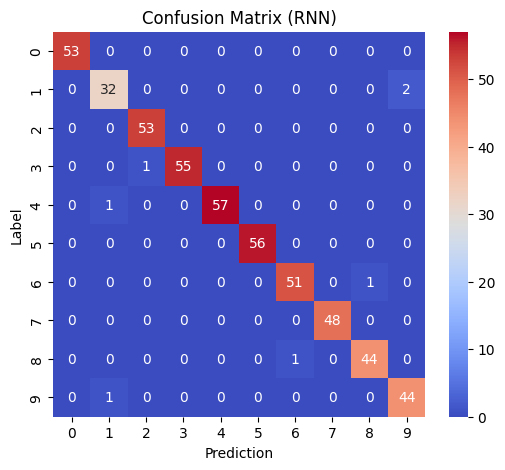

In [139]:
confusion_mtx_rnn = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mtx_rnn,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix (RNN)')
plt.show()

In [140]:
# Calcular las métricas
accuracy_rnn = accuracy_score(y_true_rnn, y_pred_rnn)
precision_rnn = precision_score(y_true_rnn, y_pred_rnn, average='weighted')
recall_rnn = recall_score(y_true_rnn, y_pred_rnn, average='weighted')
f1_rnn = f1_score(y_true_rnn, y_pred_rnn, average='weighted')
conf_matrix_rnn = confusion_matrix(y_true_rnn, y_pred_rnn)
classification_rep_rnn = classification_report(y_true_rnn, y_pred_rnn, target_names=label_names)

# Imprimir las métricas
print("--------------------------")
print("Accuracy (RNN): {:.2f}%".format(accuracy_rnn * 100))
print("Precision (RNN): {:.2f}%".format(precision_rnn * 100))
print("Recall (RNN): {:.2f}%".format(recall_rnn * 100))
print("F1-Score (RNN): {:.2f}%".format(f1_rnn * 100))
print("\nConfusion Matrix (RNN):\n", conf_matrix_rnn)
print("\nClassification Report (RNN):\n", classification_rep_rnn)

--------------------------
Accuracy (RNN): 98.60%
Precision (RNN): 98.61%
Recall (RNN): 98.60%
F1-Score (RNN): 98.60%

Confusion Matrix (RNN):
 [[53  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  0  2]
 [ 0  0 53  0  0  0  0  0  0  0]
 [ 0  0  1 55  0  0  0  0  0  0]
 [ 0  1  0  0 57  0  0  0  0  0]
 [ 0  0  0  0  0 56  0  0  0  0]
 [ 0  0  0  0  0  0 51  0  1  0]
 [ 0  0  0  0  0  0  0 48  0  0]
 [ 0  0  0  0  0  0  1  0 44  0]
 [ 0  1  0  0  0  0  0  0  0 44]]

Classification Report (RNN):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.94      0.94      0.94        34
           2       0.98      1.00      0.99        53
           3       1.00      0.98      0.99        56
           4       1.00      0.98      0.99        58
           5       1.00      1.00      1.00        56
           6       0.98      0.98      0.98        52
           7       1.00      1.00      1.00        48
       

# RNN (CNN + LSTM) / Con errores / Quedan como ejemplos

## Procesamiento de dataset

In [5]:
# Contar el número de elementos en el dataset
data_size = len(data)

# Determinar el tamaño del conjunto de validación
val_size = int(data_size * 0.2)

# Shuffle del dataset antes de dividir
shuffled_data = data.shuffle(data_size, seed=seed)

# Crear datasets de entrenamiento y validación
train_ds = shuffled_data.skip(val_size)
val_ds = shuffled_data.take(val_size)

In [6]:
m_muestras = 8000  # 8000 equivale a 1 segundo de archivo wav a 8 kHz

In [7]:
def preprocess(audio, label):
    # Normalizar y convertir a float32
    audio = tf.cast(audio, tf.float32) / 32768.0

    # Asegurarse de que todos los audios tengan exactamente las muestras deseadas
    # Recortar si el audio es más largo; rellenar con ceros si es más corto
    audio = audio[:m_muestras]  # Recorta si es más largo que las muestras deseadas
    padding = tf.maximum(0, m_muestras - tf.shape(audio)[0])  # Cantidad de padding necesaria
    audio = tf.pad(audio, [[0, padding]], "CONSTANT")  # Aplicar padding

    return audio, label

In [8]:
# Aplicar el preprocesamiento al dataset
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [9]:
# Función para obtener el espectrograma de un audio
def get_spectrogram(audio):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

# Función para crear lotes de espectrogramas con sus etiquetas
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [10]:
# Crear datasets de spectrogramas para entrenamiento y validación
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [11]:
# Función para procesar los espectrogramas y ajustarlos para la RNN
def process_spectrogram(spec, label):
    # Asegurar que la dimensión de canales sea 1 antes de eliminarla
    spec = tf.expand_dims(spec, axis=-1) if spec.shape[-1] != 1 else spec
    spec = tf.squeeze(spec, axis=-1)
    return spec, label

In [12]:
# Aplicar procesamiento adicional a los datasets de spectrogramas
train_spectrogram_ds = train_spectrogram_ds.map(process_spectrogram)
val_spectrogram_ds = val_spectrogram_ds.map(process_spectrogram)

In [13]:
# Batch y prefetch en los datasets de spectrogramas
train_spectrogram_ds = train_spectrogram_ds.batch(64).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [14]:
# Verificación rápida de la forma de los datos
for spec, label in train_spectrogram_ds.take(1):
    print("Forma del espectrograma en un lote:", spec.shape)
    print("Forma de las etiquetas en un lote:", label.shape)

Forma del espectrograma en un lote: (64, 61, 129)
Forma de las etiquetas en un lote: (64,)


## Modelo

In [15]:
# Definir la arquitectura de la RNN (CNN + LSTM)
model_cnlst = Sequential([
    # Capas convolucionales
    Conv2D(64, (3, 3), strides=(1, 1), activation='relu', input_shape=(61, 129, 1)),
    Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),
    Conv2D(16, (3, 3), strides=(1, 1), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Flatten(),  # Aplanar la salida de las capas convolucionales
    Dropout(0.5),
    # Reformar para pasar a la capa LSTM
    Reshape((-1, 32)),  # Valor de input_dim de la capa LSTM
    # Capa recurrente LSTM
    LSTM(32, return_sequences=False, dropout=0.5),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [16]:
# Resumen del modelo
model_cnlst.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 127, 64)       640       
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 125, 32)       18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 60, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 58, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 29, 16)        0         
 g2D)                                                   

In [26]:
# Compilación del modelo
model_cnlst.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenamiento del modelo RNN
EPOCHS = 30
print("Inicio del Entrenamiento RNN\n-------------------------")
history_rnn = model_cnlst.fit(train_spectrogram_ds, epochs=EPOCHS,
                          validation_data=val_spectrogram_ds)
print("-------------------------\nFin del Entrenamiento RNN")

Inicio del Entrenamiento RNN
-------------------------
Epoch 1/30
32/32 [==============================] - 5s 60ms/step - loss: 2.3032 - accuracy: 0.1015 - val_loss: 2.3020 - val_accuracy: 0.1200
Epoch 2/30
32/32 [==============================] - 2s 46ms/step - loss: 2.3031 - accuracy: 0.1015 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/30
32/32 [==============================] - 2s 48ms/step - loss: 2.3031 - accuracy: 0.0945 - val_loss: 2.3032 - val_accuracy: 0.0980
Epoch 4/30
32/32 [==============================] - 2s 73ms/step - loss: 2.3031 - accuracy: 0.1005 - val_loss: 2.3023 - val_accuracy: 0.1240
Epoch 5/30
32/32 [==============================] - 2s 49ms/step - loss: 2.3029 - accuracy: 0.0965 - val_loss: 2.3022 - val_accuracy: 0.0900
Epoch 6/30
32/32 [==============================] - 2s 46ms/step - loss: 2.3030 - accuracy: 0.0930 - val_loss: 2.3040 - val_accuracy: 0.0760
Epoch 7/30
32/32 [==============================] - 2s 46ms/step - loss: 2.3029 - accuracy: 0.1040 

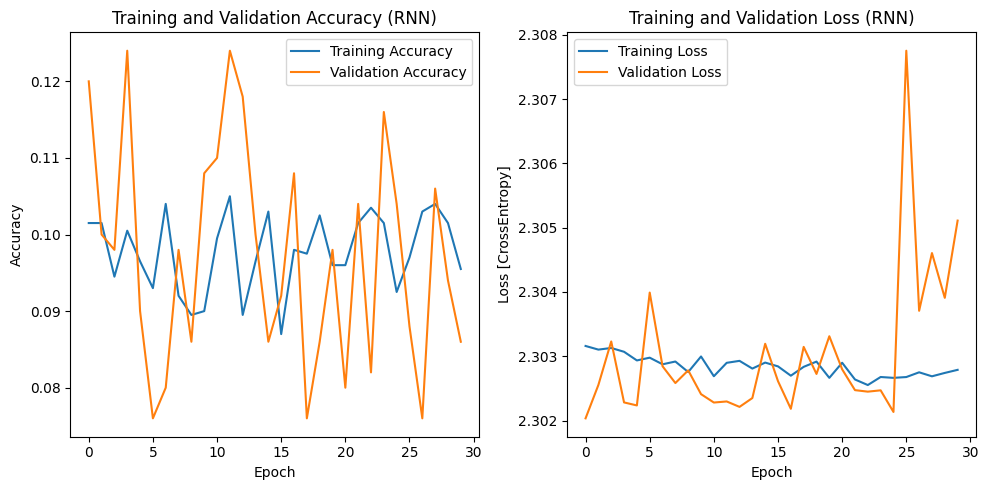

In [27]:
# Obtener las métricas de precisión y pérdida del historial
acc_rnn = history_rnn.history['accuracy']
val_acc_rnn = history_rnn.history['val_accuracy']

loss_rnn = history_rnn.history['loss']
val_loss_rnn = history_rnn.history['val_loss']

epochs_range_rnn = range(len(acc_rnn))  # Número de épocas

# Gráficos de precisión y pérdida para la RNN
plt.figure(figsize=(10, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range_rnn, acc_rnn, label='Training Accuracy')
plt.plot(epochs_range_rnn, val_acc_rnn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (RNN)')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range_rnn, loss_rnn, label='Training Loss')
plt.plot(epochs_range_rnn, val_loss_rnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('Training and Validation Loss (RNN)')
plt.legend()

plt.tight_layout()
plt.show()

## Predicciones y Métricas

In [28]:
# Predicciones en el conjunto de prueba
y_pred_rnn = model_cnlst.predict(val_spectrogram_ds)

8/8 [==============================] - 1s 26ms/step


In [ ]:
# Por cada prediccion obtengo los logits (si tuviera la softmax seria una distribucion de probabilidad), el
# indice del valor mas alto corresponde a la clase predicha.
y_pred[0]

In [29]:
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)

In [ ]:
y_pred[0]

In [30]:
# Obtener las etiquetas verdaderas del conjunto de validación
y_true_rnn = tf.concat(list(val_spectrogram_ds.map(lambda spec, lab: lab)), axis=0)

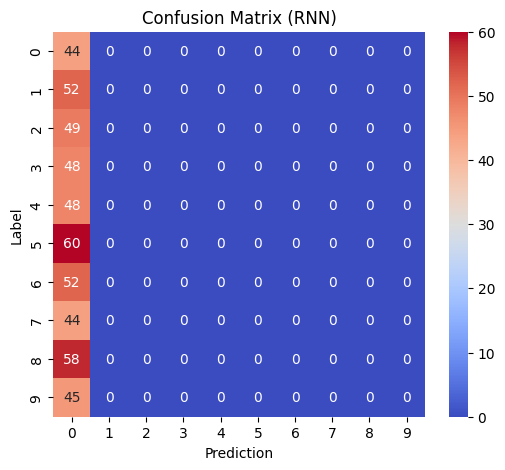

In [31]:
confusion_mtx_rnn = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mtx_rnn,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix (RNN)')
plt.show()

## Modelo

In [ ]:
# Compilación del modelo
model_cnlst.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenamiento del modelo RNN
EPOCHS = 30
print("Inicio del Entrenamiento RNN\n-------------------------")
history = model_cnlst.fit(X_train, y_train, epochs=EPOCHS,
                          validation_data=(X_val, y_val), batch_size=8,
                          callbacks=[early_stopping, model_checkpoint])
print("-------------------------\nFin del Entrenamiento RNN")

Inicio del Entrenamiento RNN
-------------------------
Epoch 1/30
32/32 [==============================] - 4s 40ms/step - loss: 2.2983 - accuracy: 0.1015 - val_loss: 2.2747 - val_accuracy: 0.0980
Epoch 2/30
32/32 [==============================] - 1s 26ms/step - loss: 2.0137 - accuracy: 0.2290 - val_loss: 1.6884 - val_accuracy: 0.3120
Epoch 3/30
32/32 [==============================] - 1s 31ms/step - loss: 1.5977 - accuracy: 0.3185 - val_loss: 1.4866 - val_accuracy: 0.3580
Epoch 4/30
32/32 [==============================] - 1s 26ms/step - loss: 1.3774 - accuracy: 0.4365 - val_loss: 1.2900 - val_accuracy: 0.5040
Epoch 5/30
32/32 [==============================] - 1s 31ms/step - loss: 1.2093 - accuracy: 0.5295 - val_loss: 1.1703 - val_accuracy: 0.5240
Epoch 6/30
32/32 [==============================] - 1s 30ms/step - loss: 1.0660 - accuracy: 0.5595 - val_loss: 0.9453 - val_accuracy: 0.6000
Epoch 7/30
32/32 [==============================] - 1s 26ms/step - loss: 0.9609 - accuracy: 0.5995 

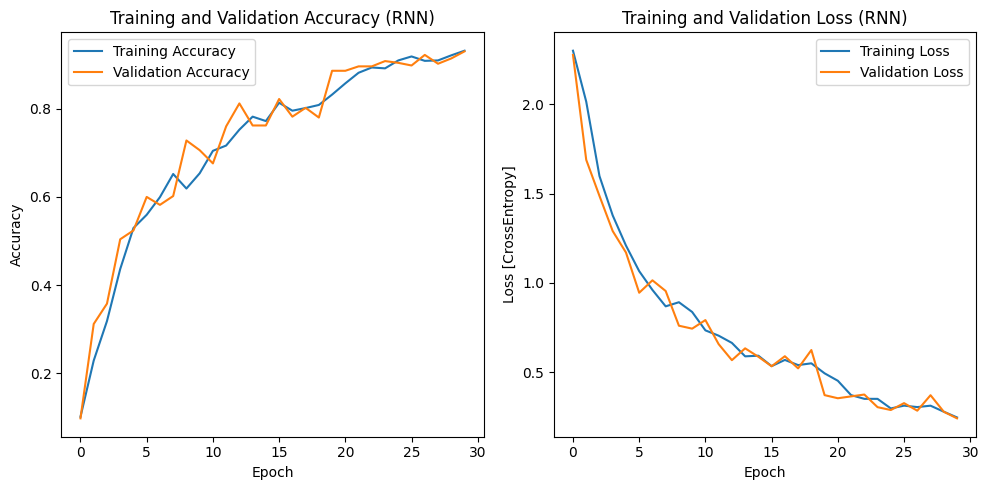

In [ ]:
# Obtener las métricas de precisión y pérdida del historial
acc_rnn = history_rnn.history['accuracy']
val_acc_rnn = history_rnn.history['val_accuracy']

loss_rnn = history_rnn.history['loss']
val_loss_rnn = history_rnn.history['val_loss']

epochs_range_rnn = range(len(acc_rnn))  # Número de épocas

# Gráficos de precisión y pérdida para la RNN
plt.figure(figsize=(10, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range_rnn, acc_rnn, label='Training Accuracy')
plt.plot(epochs_range_rnn, val_acc_rnn, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (RNN)')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range_rnn, loss_rnn, label='Training Loss')
plt.plot(epochs_range_rnn, val_loss_rnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('Training and Validation Loss (RNN)')
plt.legend()

plt.tight_layout()
plt.show()

## Predicciones y Métricas

In [ ]:
# Predicciones en el conjunto de prueba
y_pred_rnn = model_rnn.predict(val_spectrogram_ds)

8/8 [==============================] - 0s 26ms/step


In [ ]:
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)

In [ ]:
# Obtener las etiquetas verdaderas del conjunto de validación
y_true_rnn = tf.concat(list(val_spectrogram_ds.map(lambda spec, lab: lab)), axis=0)

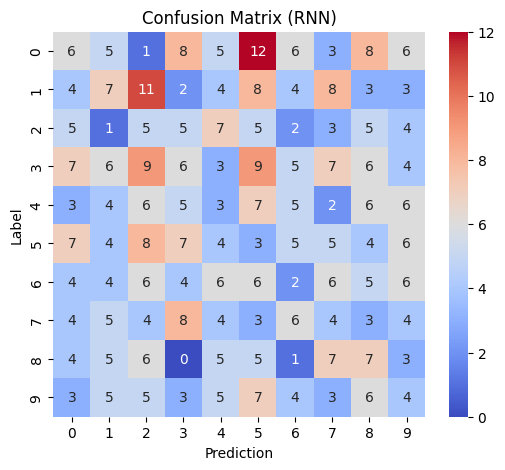

In [ ]:
confusion_mtx_rnn = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mtx_rnn,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix (RNN)')
plt.show()

In [ ]:
# Calcular las métricas
accuracy_rnn = accuracy_score(y_true_rnn, y_pred_rnn)
precision_rnn = precision_score(y_true_rnn, y_pred_rnn, average='weighted')
recall_rnn = recall_score(y_true_rnn, y_pred_rnn, average='weighted')
f1_rnn = f1_score(y_true_rnn, y_pred_rnn, average='weighted')
conf_matrix_rnn = confusion_matrix(y_true_rnn, y_pred_rnn)
classification_rep_rnn = classification_report(y_true_rnn, y_pred_rnn, target_names=label_names)

# Imprimir las métricas
print("--------------------------")
print("Accuracy (RNN): {:.2f}%".format(accuracy_rnn * 100))
print("Precision (RNN): {:.2f}%".format(precision_rnn * 100))
print("Recall (RNN): {:.2f}%".format(recall_rnn * 100))
print("F1-Score (RNN): {:.2f}%".format(f1_rnn * 100))
print("\nConfusion Matrix (RNN):\n", conf_matrix_rnn)
print("\nClassification Report (RNN):\n", classification_rep_rnn)

--------------------------
Accuracy (RNN): 9.40%
Precision (RNN): 9.67%
Recall (RNN): 9.40%
F1-Score (RNN): 9.43%

Confusion Matrix (RNN):
 [[ 6  5  1  8  5 12  6  3  8  6]
 [ 4  7 11  2  4  8  4  8  3  3]
 [ 5  1  5  5  7  5  2  3  5  4]
 [ 7  6  9  6  3  9  5  7  6  4]
 [ 3  4  6  5  3  7  5  2  6  6]
 [ 7  4  8  7  4  3  5  5  4  6]
 [ 4  4  6  4  6  6  2  6  5  6]
 [ 4  5  4  8  4  3  6  4  3  4]
 [ 4  5  6  0  5  5  1  7  7  3]
 [ 3  5  5  3  5  7  4  3  6  4]]

Classification Report (RNN):
               precision    recall  f1-score   support

           0       0.13      0.10      0.11        60
           1       0.15      0.13      0.14        54
           2       0.08      0.12      0.10        42
           3       0.12      0.10      0.11        62
           4       0.07      0.06      0.06        47
           5       0.05      0.06      0.05        53
           6       0.05      0.04      0.04        49
           7       0.08      0.09      0.09        45
           